In [1]:
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

%matplotlib inline
 
warnings.filterwarnings("ignore")
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
import logging

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

In [2]:
edata = pd.read_csv("energydata.csv")

In [3]:
edata['date']= pd.to_datetime(edata['date'])

In [4]:
edata['hour']=edata['date'].dt.hour
edata['dayofweek']=edata['date'].dt.dayofweek
edata['month']=edata['date'].dt.month
edata['year']=edata['date'].dt.year
edata['weekofyear']=edata['date'].dt.weekofyear

In [5]:
edata= edata.set_index('date').resample('H').mean().reset_index() #aggregating into hourly basis

In [6]:
edata.drop(['rv1','rv2'], axis=1, inplace=True)

In [7]:
ed_darts= edata[['date', 'appl']]

In [8]:
ed_darts.head()

date        appl
0 2016-01-11 17:00:00   55.000000
1 2016-01-11 18:00:00  176.666667
2 2016-01-11 19:00:00  173.333333
3 2016-01-11 20:00:00  125.000000
4 2016-01-11 21:00:00  103.333333

In [9]:
series= TimeSeries.from_dataframe(ed_darts, time_col='date')

In [10]:
#ed_darts.set_index('date', inplace=True)

In [11]:
series

<TimeSeries (DataArray) (date: 3290, component: 1, sample: 1)>
array([[[ 55.        ]],

       [[176.66666667]],

       [[173.33333333]],

       ...,

       [[135.        ]],

       [[180.        ]],

       [[430.        ]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-01-11T17:00:00 ... 2016-05-27T18:00:00
  * component  (component) object 'appl'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [104]:
#start = pd.Timestamp('2016-01-11 17:00:00')
ed_dts_metrics = pd.DataFrame()

def plot_backtest(series, forecast, model_name):
    idx = 0
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()
    
def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_, 
             'R2': r2_score_}
    
    ed_darts= pd.DataFrame(dict_, index = [model_name])
    
    return(ed_darts.round(decimals = 2))

  0%|          | 0/1646 [00:00<?, ?it/s]

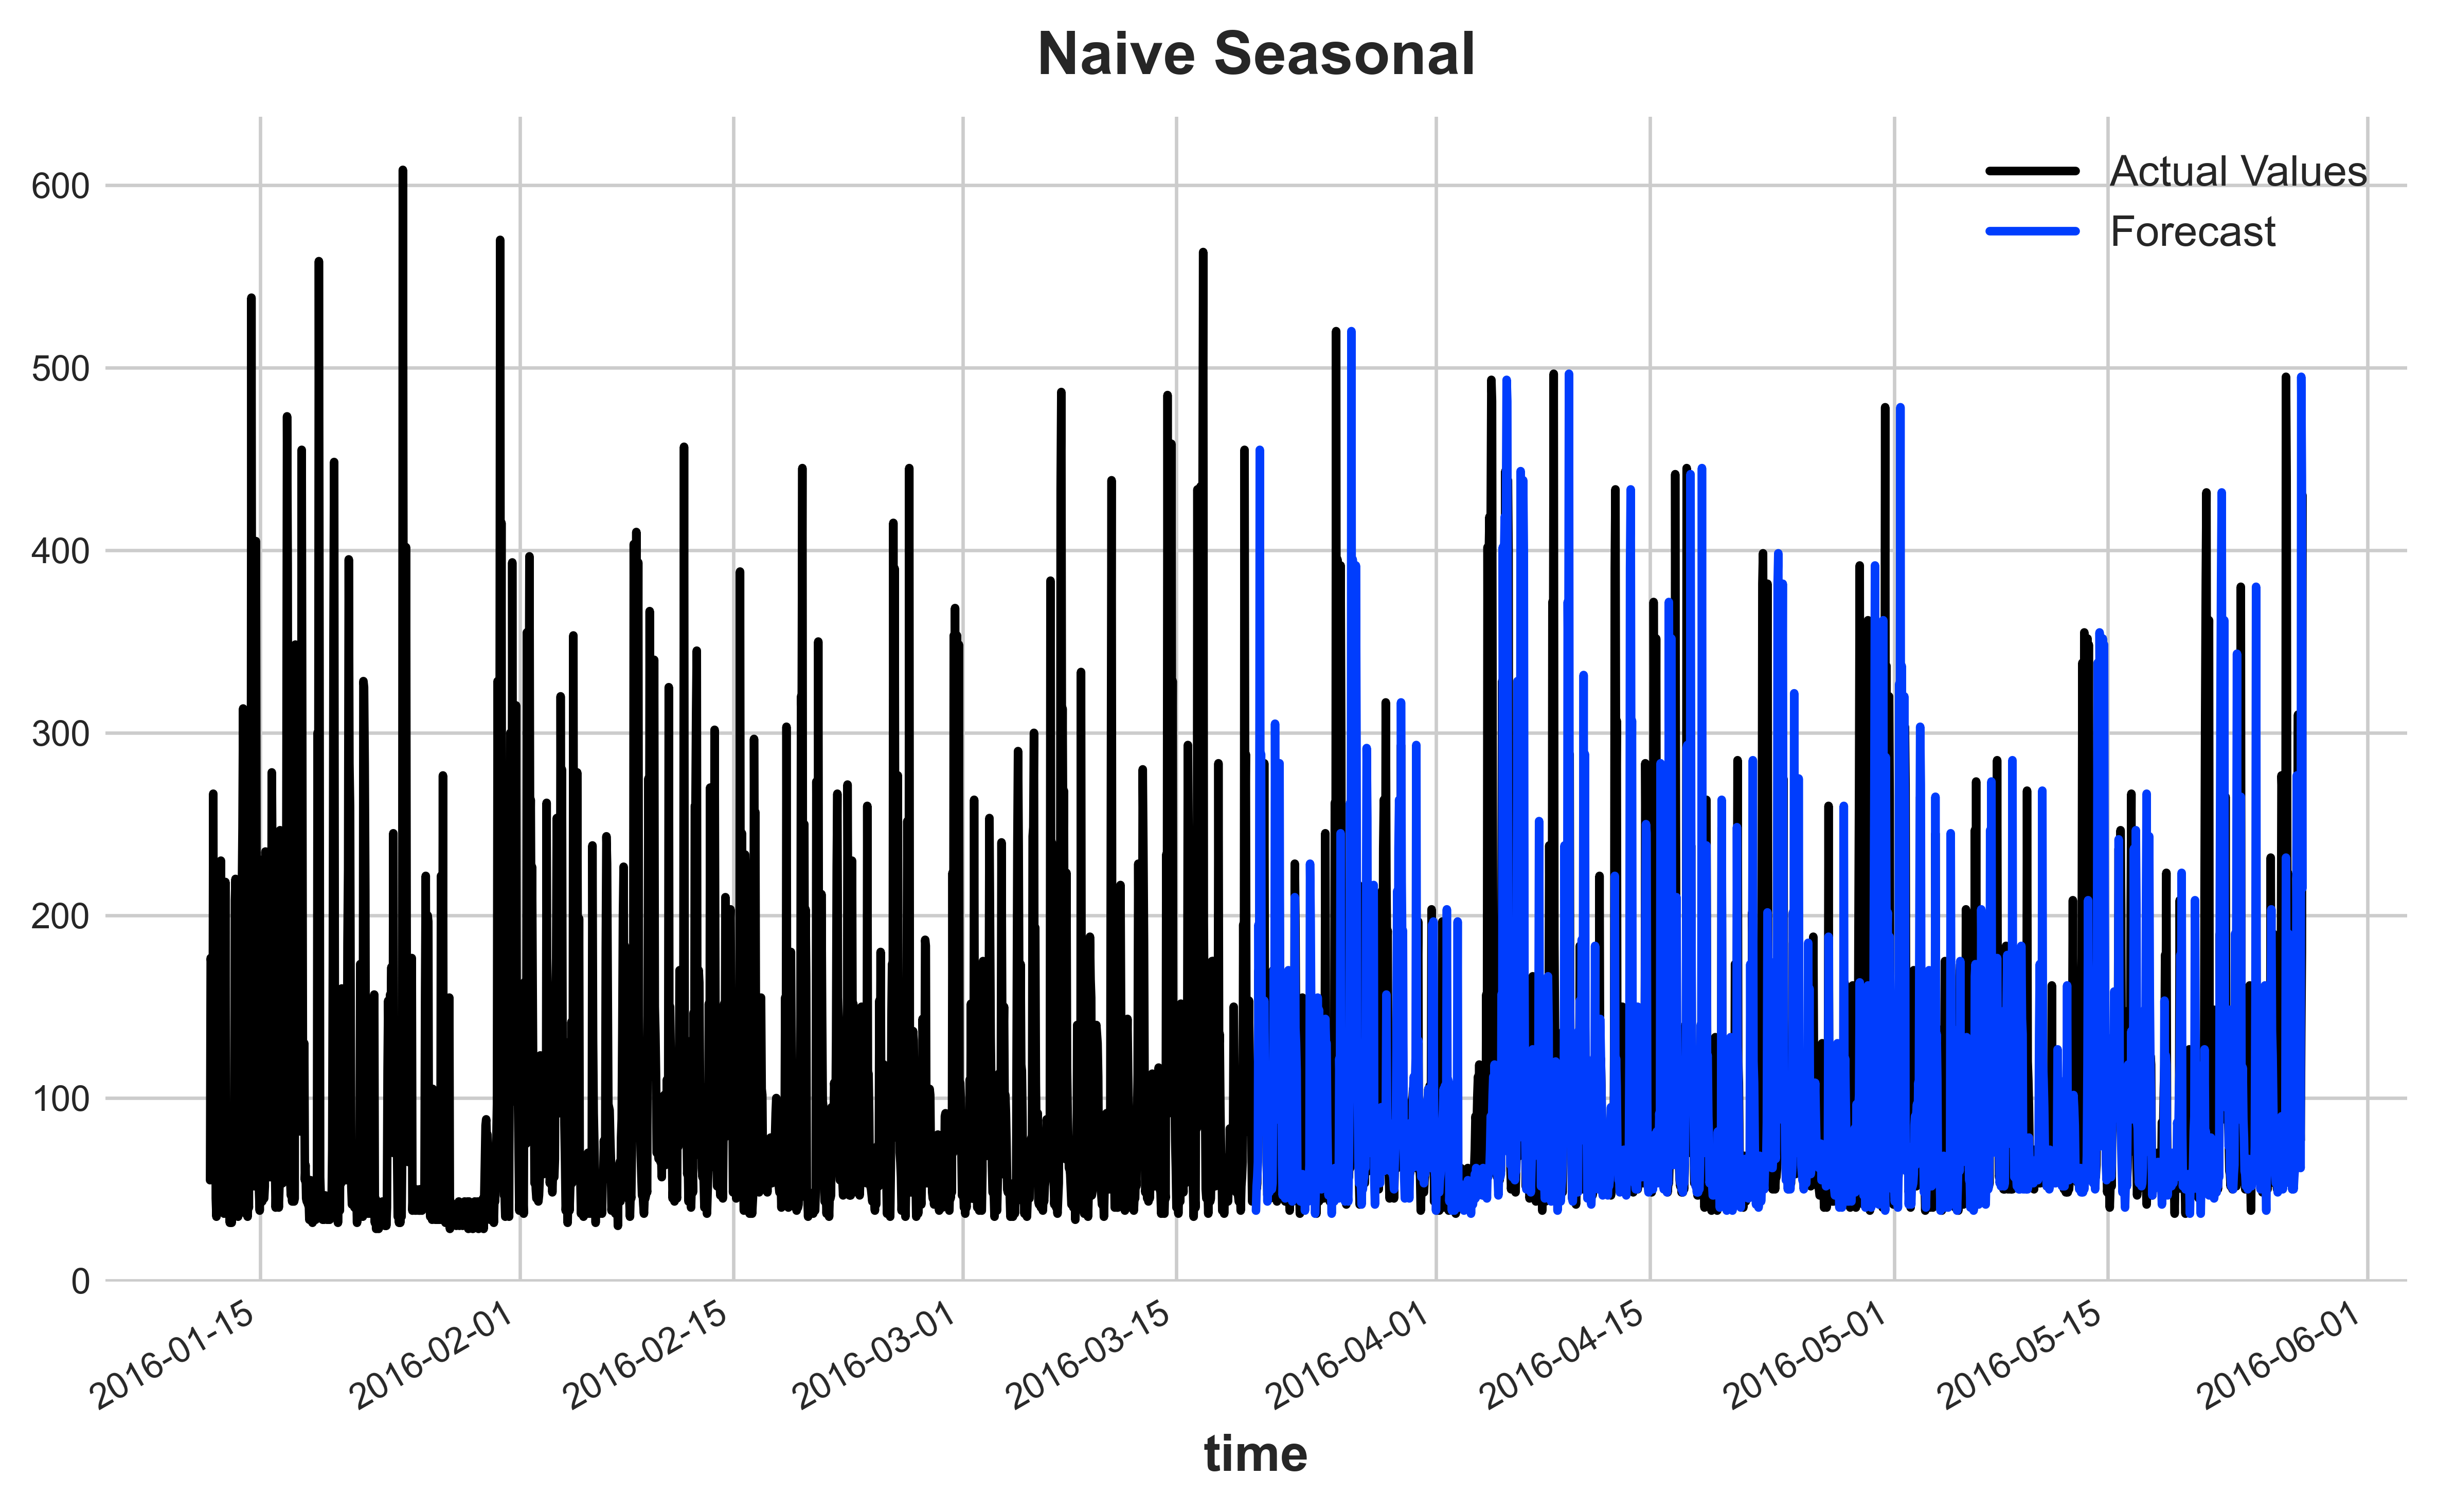

MAE   RMSE   MAPE  SMAPE    R2
Naive Seasonal  47.39  87.68  43.63  35.63 -0.34

In [112]:
model = NaiveSeasonal(K = 24)
model_name = 'Naive Seasonal'

plt.figure(figsize = (8, 5))
forecast = model.historical_forecasts(series, forecast_horizon=1, verbose=True)
plot_backtest(series, forecast, model_name)
ed_darts_naive = print_metrics(series, forecast, model_name)
#ed_darts_metrics = ed_darts_metrics.append(ed_darts_naive)

plt.show()
ed_darts_naive


## Holt Winter exponential forecasting

  0%|          | 0/1646 [00:00<?, ?it/s]

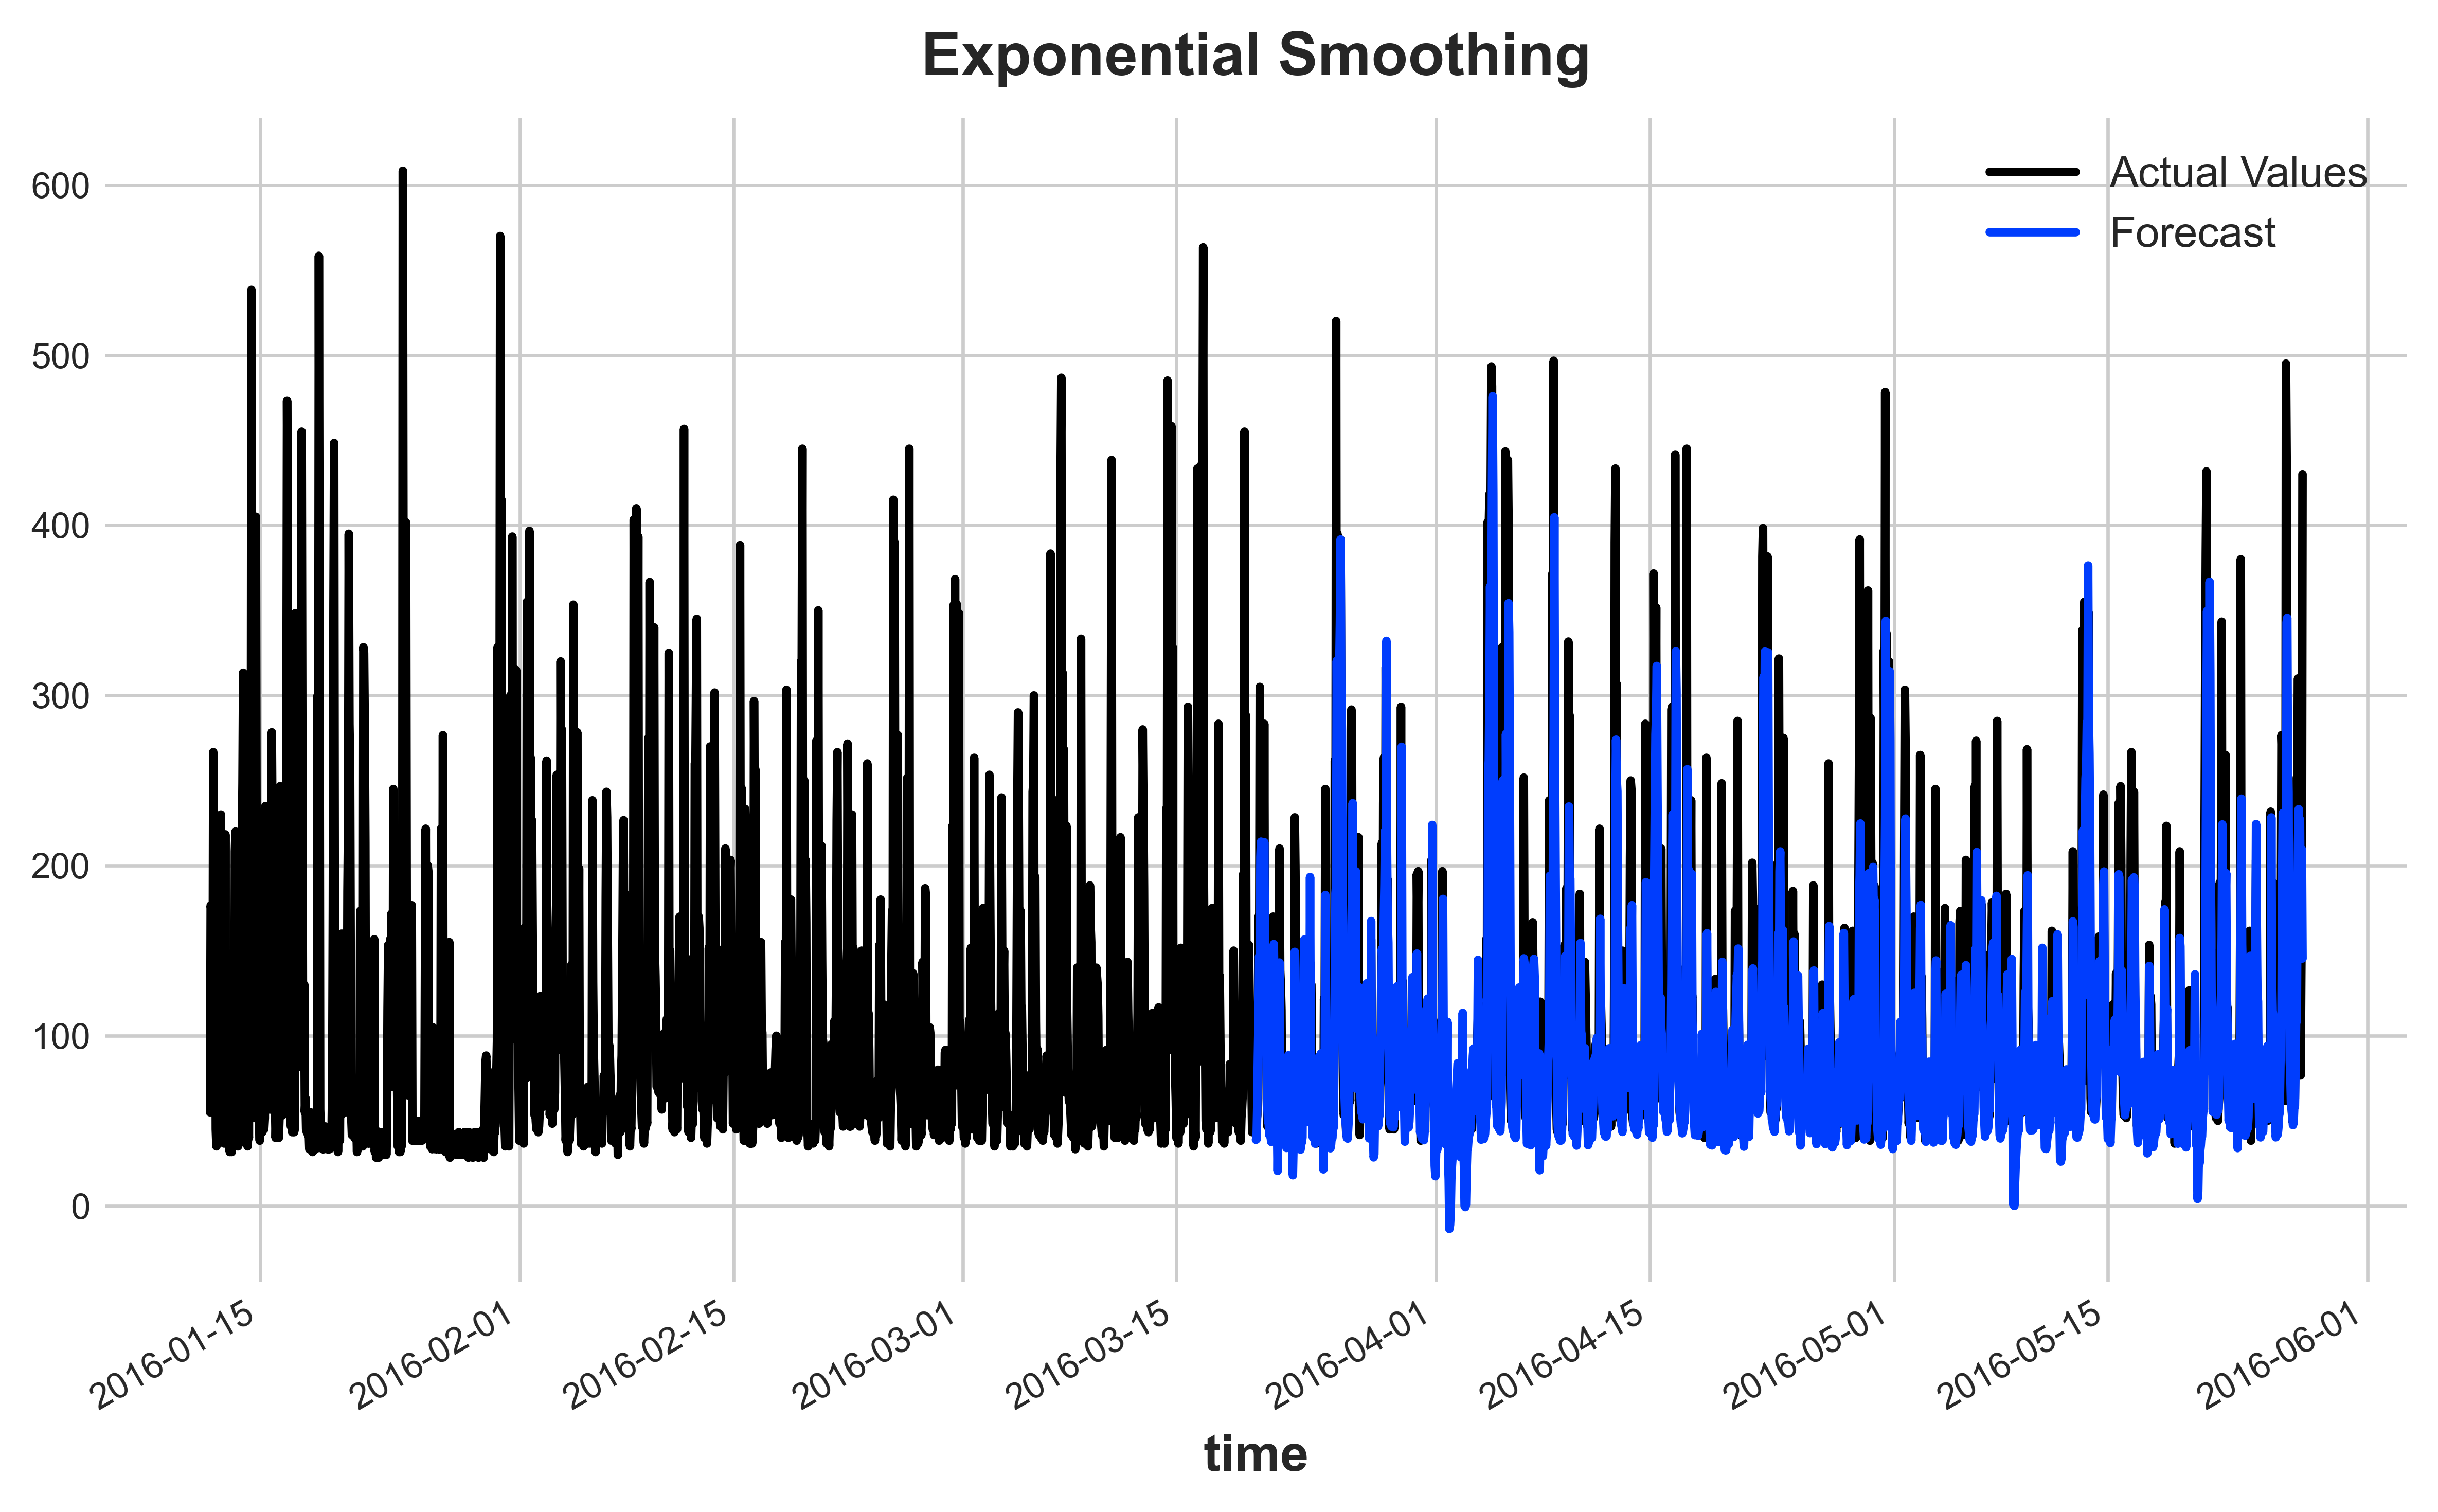

MAE  RMSE   MAPE  SMAPE   R2
Exponential Smoothing  35.18  58.5  34.07  33.04  0.4

In [113]:
model = ExponentialSmoothing(seasonal_periods = 24)
model_name = 'Exponential Smoothing'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, forecast_horizon=1, verbose=True)
plot_backtest(series, forecast, model_name)
ed_darts_exp = print_metrics(series, forecast, model_name)
#ed_darts_metrics = ed_darts_metrics.append(ed_darts_exp)

plt.show()
ed_darts_exp

## Linear Regression forecasting

  0%|          | 0/1646 [00:00<?, ?it/s]

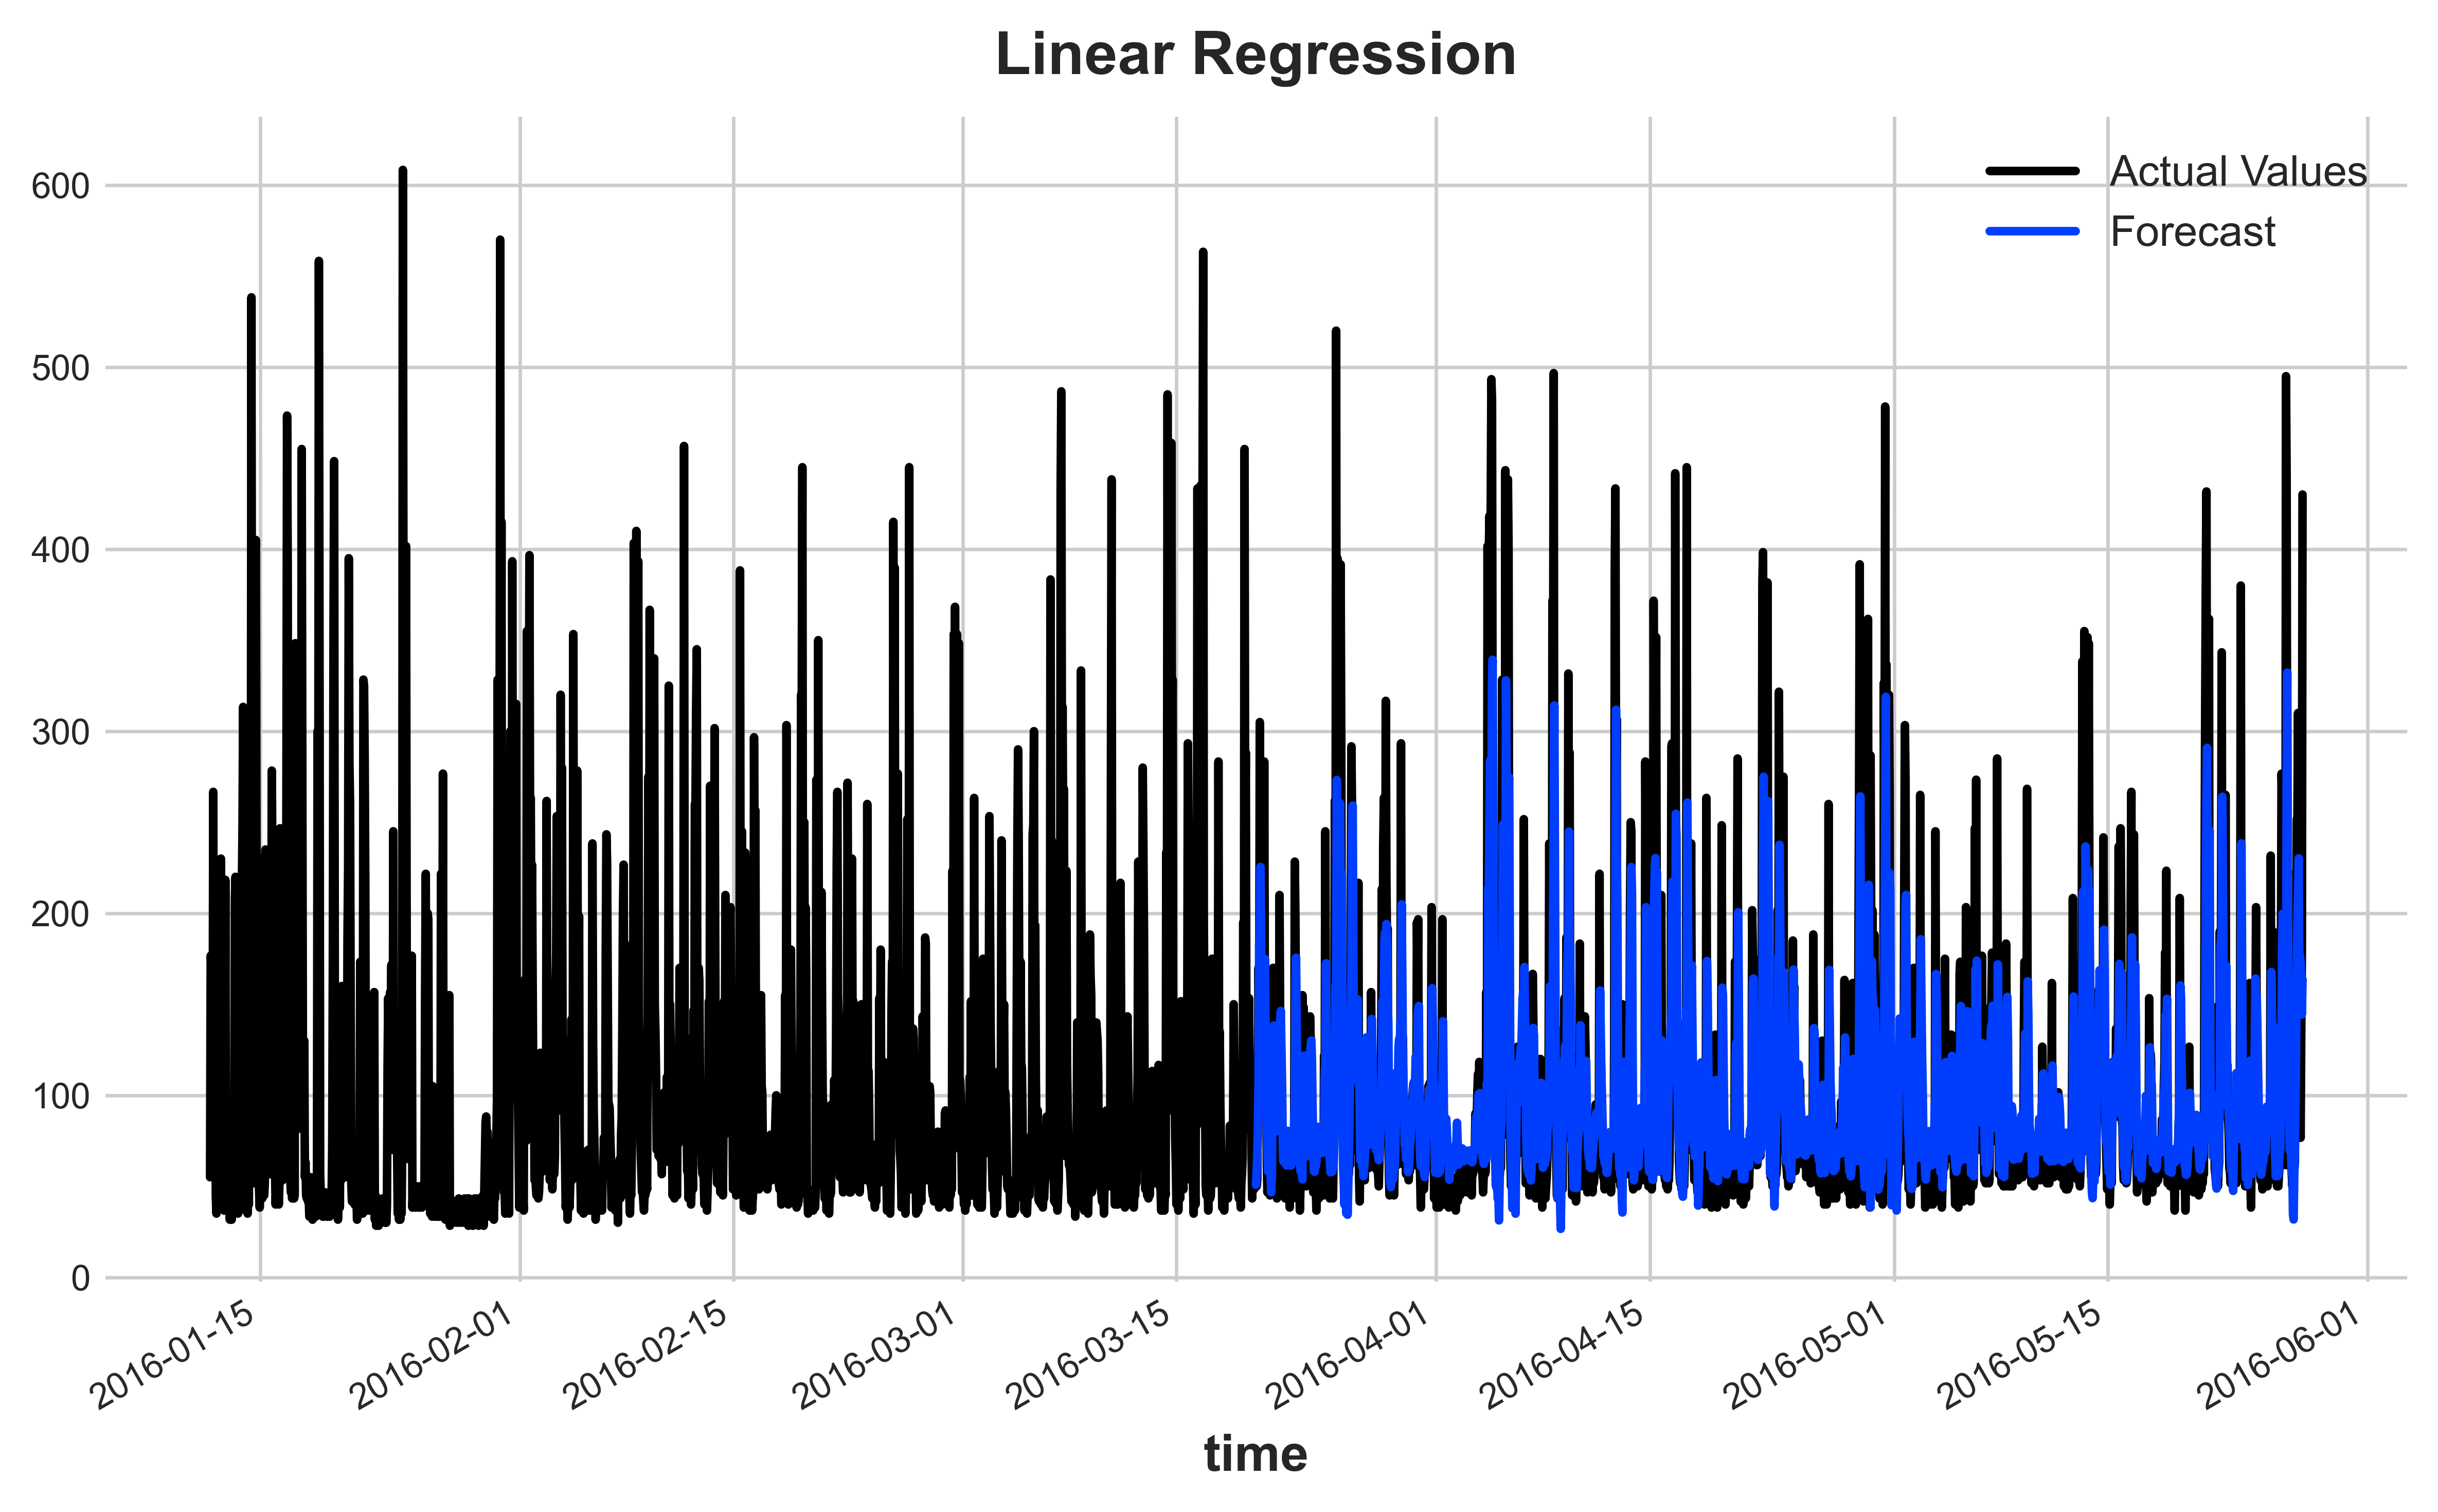

MAE   RMSE   MAPE  SMAPE    R2
Linear Regression  33.74  57.12  32.54   29.2  0.43

In [111]:
model = LinearRegressionModel(lags = 24)
model_name = 'Linear Regression'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, forecast_horizon=1, verbose=True)
plot_backtest(series, forecast, model_name)
ed_darts_lr = print_metrics(series, forecast, model_name)
#ed_darts_metrics = df_metrics.append(ed_darts_lr)

plt.show()
ed_darts_lr

In [116]:
model.diagnositics

AttributeError: 'ExponentialSmoothing' object has no attribute 'diagnositics'

## Another model

In [18]:
edata

date        appl        lgt      temp1       rh_1  \
0    2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778   
1    2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028   
2    2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556   
3    2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333   
4    2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
0     19.200000  44.626528  19.790000  44.897778  18.932778  ...  733.750000   
1     19.268889  44.438889  19.770000  44.863333  18.908333  ...  734.266667   
2     19.925556  46.061667  20.052222  47.227361  18.969444  ...  734.791667   
3     20.251111  45.632639  20.213889  47.268889  19.190833  ...  735.283333   
4     20.587778  44.961111  20.373333  46.164444  19.425556  ...  735.566667   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
0     92.000000   6.166667   53.416667   5.050000  17.0        0.0    1.0   
1     91.583333   5.416667   40.000000   4.658333  18.0        0.0    1.0   
2     89.750000   6.000000   40.000000   4.391667  19.0        0.0    1.0   
3     87.583333   6.000000   40.000000   4.016667  20.0        0.0    1.0   
4     87.416667   6.000000   40.000000   3.816667  21.0        0.0    1.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
0     2016.0         2.0  
1     2016.0         2.0  
2     2016.0         2.0  
3     2016.0         2.0  
4     2016.0         2.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[3290 rows x 32 columns]

In [35]:
from darts.timeseries import TimeSeries
from darts.models import (
    LinearRegressionModel,
    ExponentialSmoothing,
    ARIMA,
    RandomForest,
    Theta,
    NaiveSeasonal,
    RegressionEnsembleModel,
    NBEATSModel
)

from darts.metrics import mape, mse, rmse

In [78]:
ed_dt2= edata[['date', 'appl']]

In [27]:
darts_ts= TimeSeries.from_dataframe(ed_dt2, time_col='date')

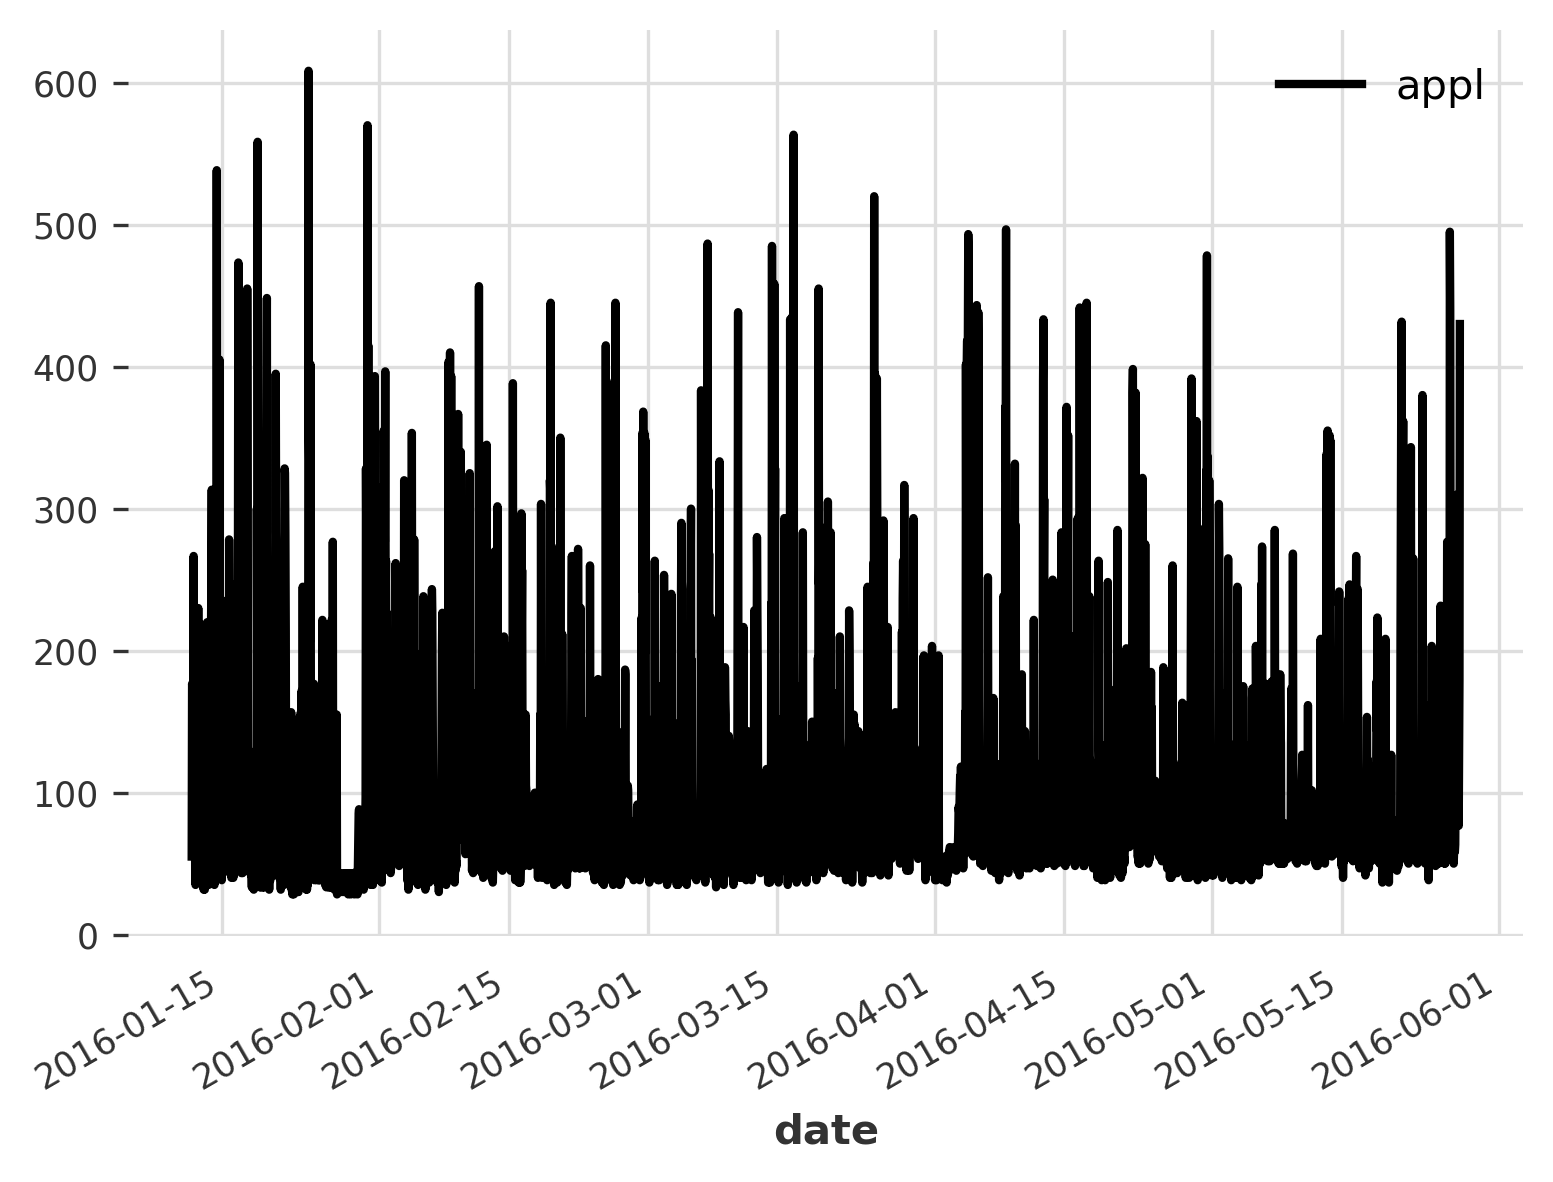

In [29]:
col= 'appl'
darts_ts[col].plot()

In [31]:
#valid_ts= darts_ts.drop_be[pd.Timestamp('2016-04-16')]
train, test= darts_ts[col].split_before(0.7)

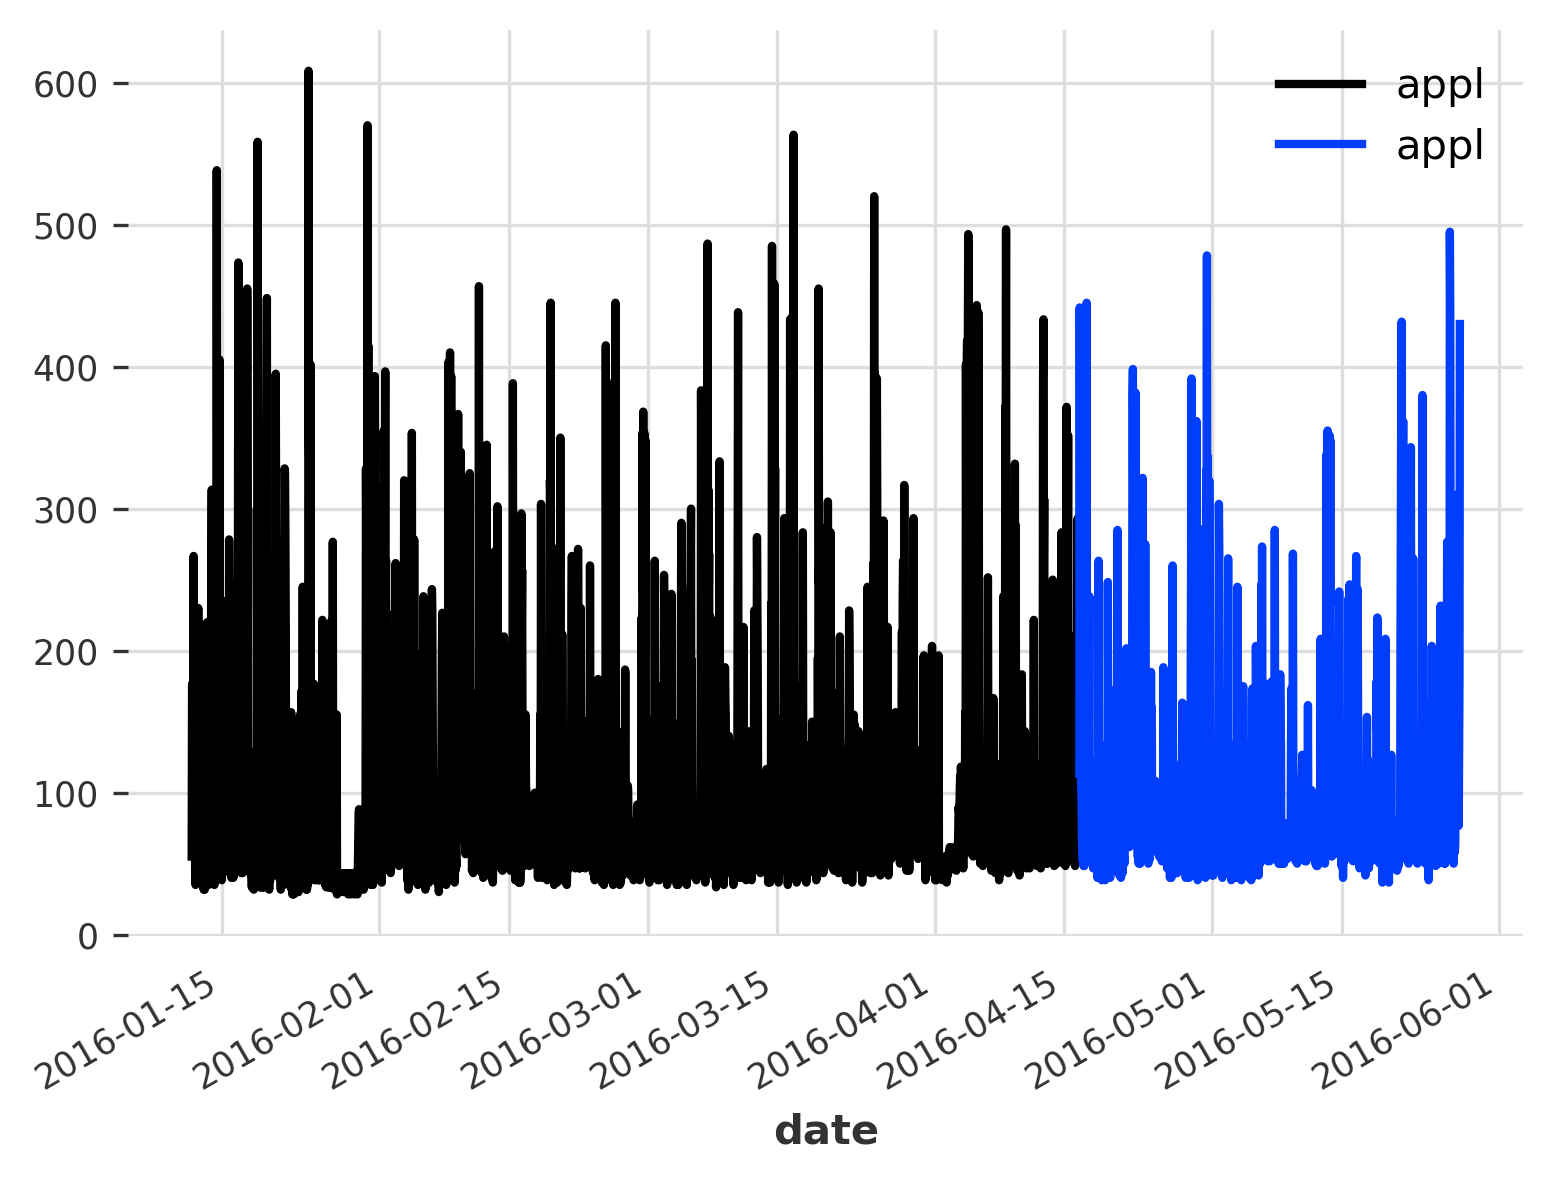

In [33]:
#print(pd.concat([train.describe(), test.describe()], axis=1))
train.plot(); test.plot()

In [68]:
model0= Theta(seasonality_period=12)
model1= LinearRegressionModel(lags=12)
model2= ExponentialSmoothing(seasonal_periods=12)
model3= NaiveSeasonal()
model4= ARIMA(p=3, d=0, q=1)
model5= RandomForest(lags=12, n_estimators=500)

In [69]:
models= {
    "Theta": model0,
    'LinearRegresion': model1,
    'ExponentialSmoothing': model2,
    'NaiveSeasonal': model3,
    'ARIMA': model4,
    'RandomForest': model5
}

Theta
LinearRegresion
ExponentialSmoothing
NaiveSeasonal
ARIMA
RandomForest


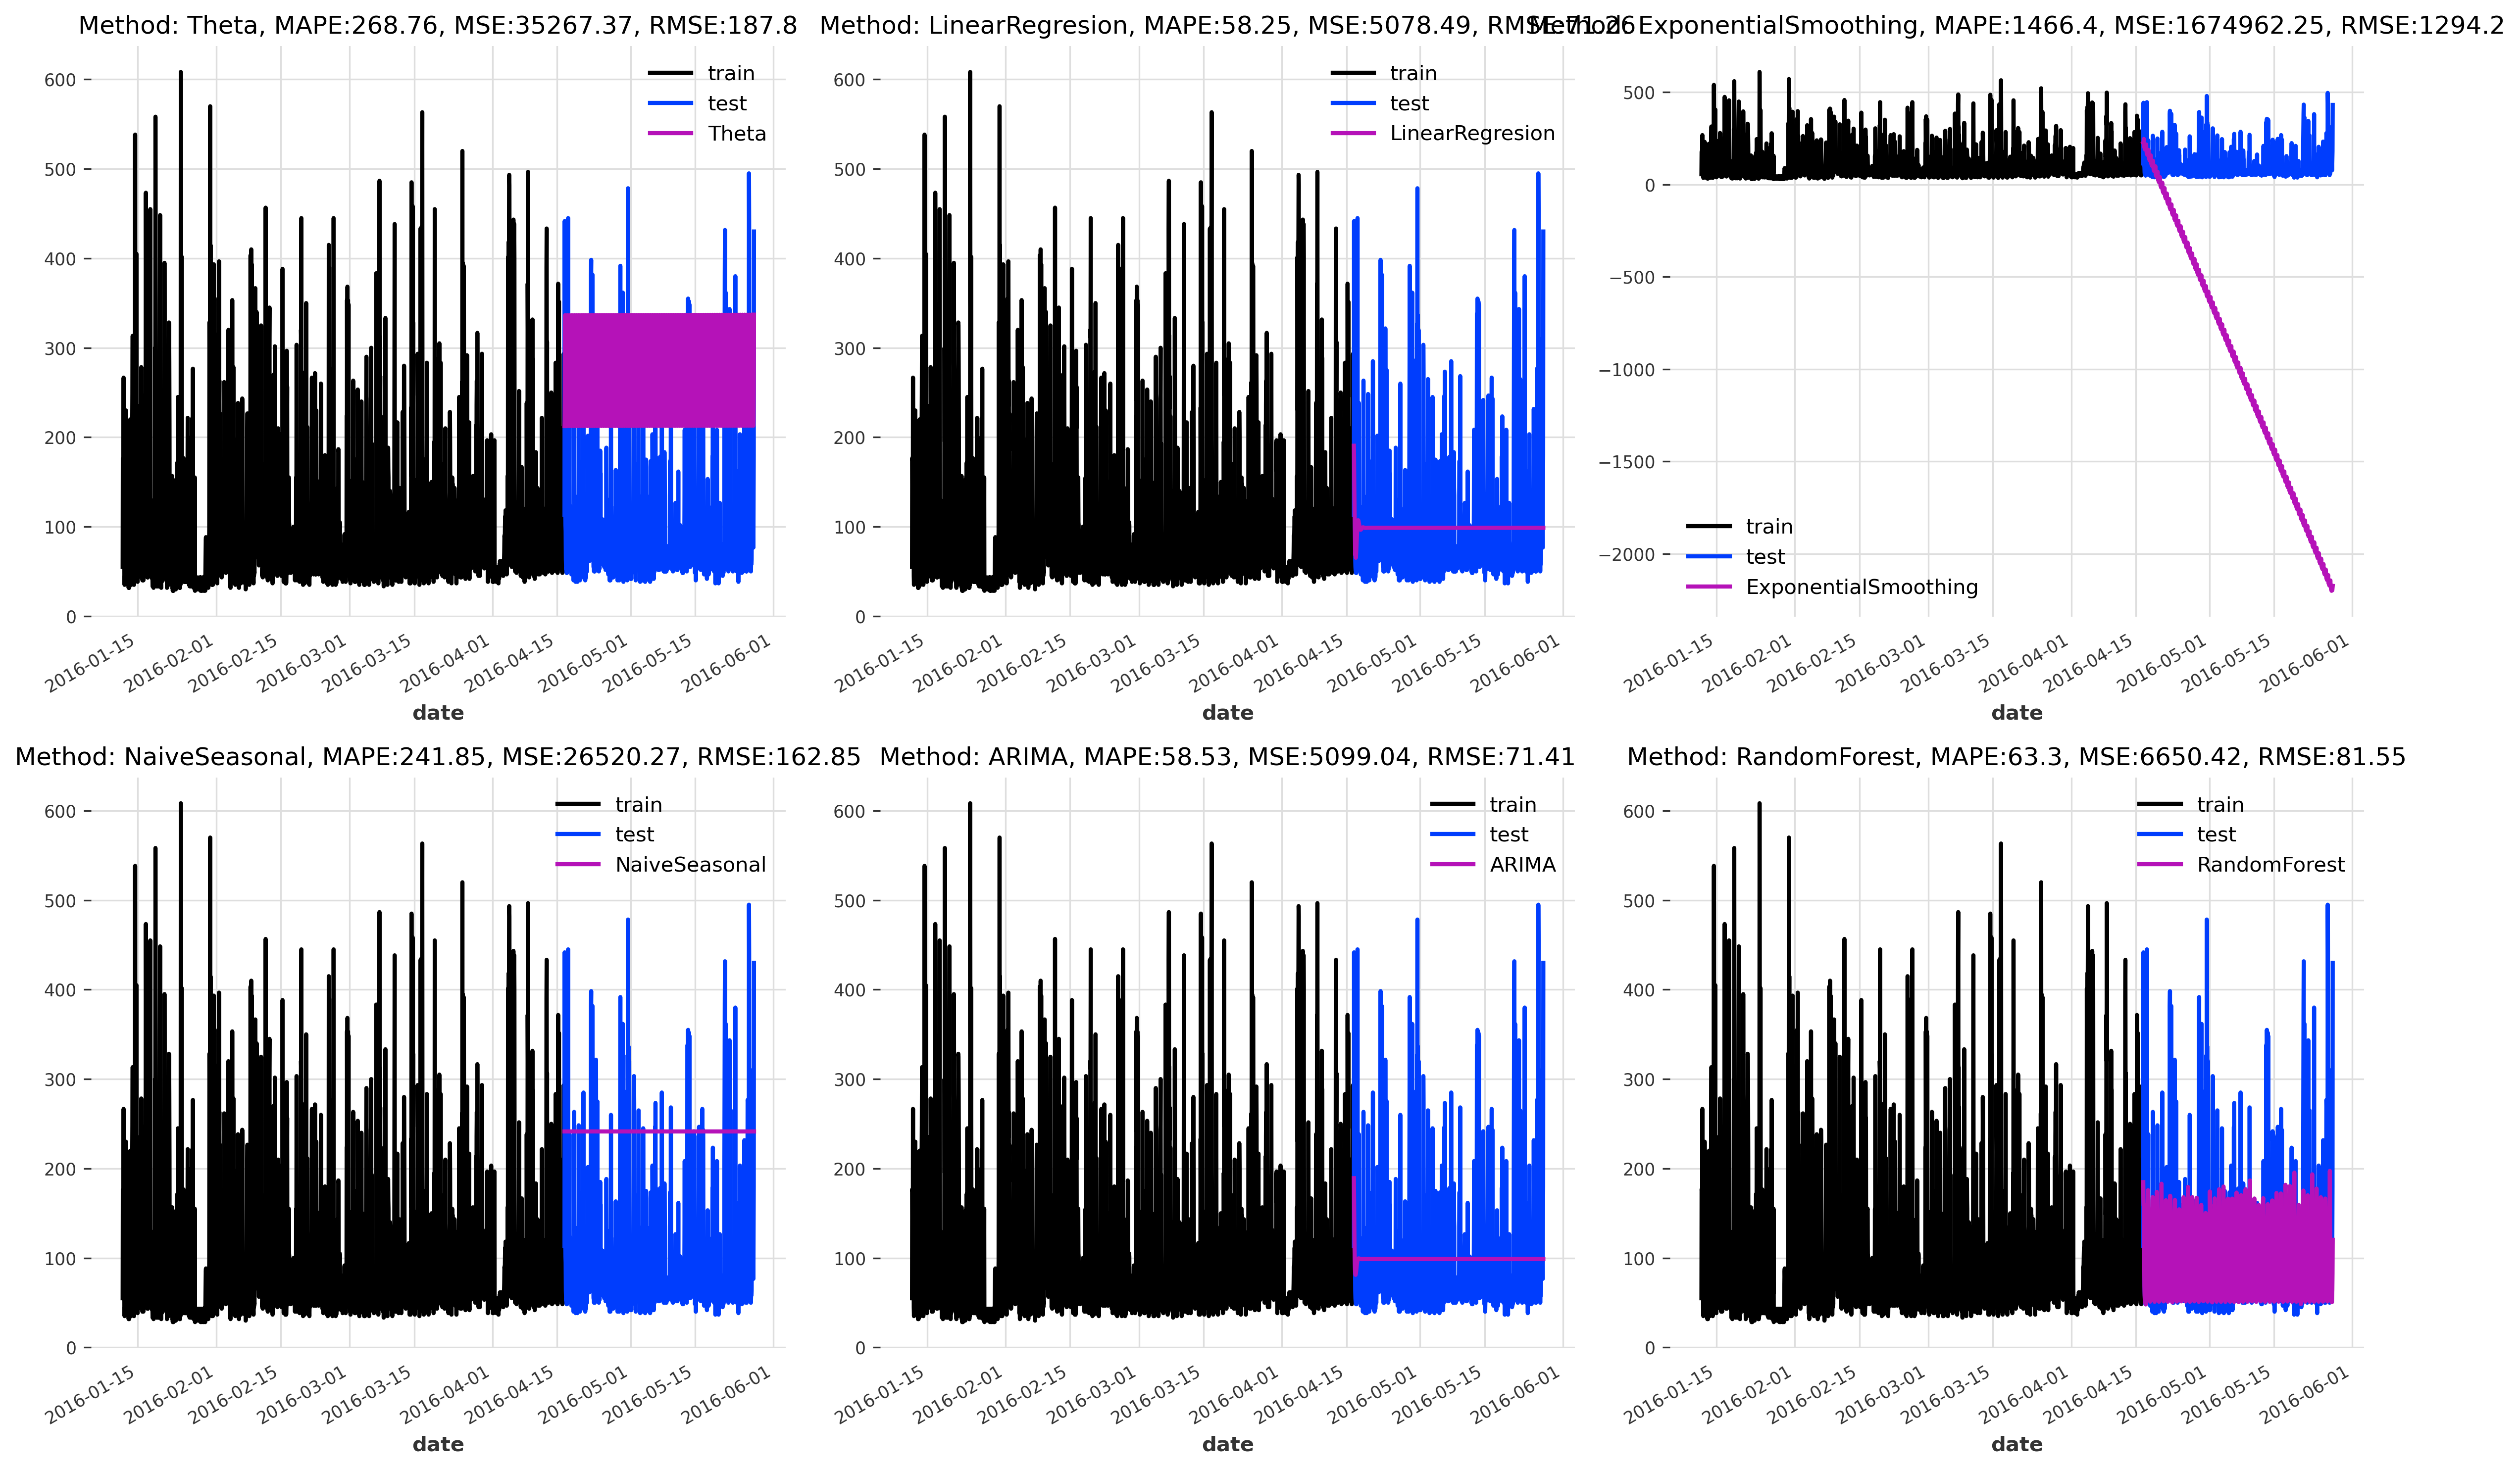

In [70]:
fig= plt.figure(figsize=(16,10))
for i, (name, model) in enumerate(models.items()):
    print(name)
    model.fit(series= train)
    predictions= model.predict(n=len(test))
    mape_score= round(mape(test, predictions), 2)
    mse_score= round(mse(test, predictions), 2)
    rmse_score= round(rmse(test, predictions), 2)
    
    fig.add_subplot(2,3, i+1)
    train.plot(label='train'); test.plot(label='test'); predictions.plot(label=name)
    plt.title(f'Method: {name}, MAPE:{mape_score}, MSE:{mse_score}, RMSE:{rmse_score}');plt.legend()
fig.tight_layout()
plt.show()

In [101]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="red",
    style=".-",
    markeredgecolor="blue",
    markerfacecolor="blue",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [88]:
ed_dt2

date        appl  Time       Lag_1
0    2016-01-11 17:00:00   55.000000     0         NaN
1    2016-01-11 18:00:00  176.666667     1   55.000000
2    2016-01-11 19:00:00  173.333333     2  176.666667
3    2016-01-11 20:00:00  125.000000     3  173.333333
4    2016-01-11 21:00:00  103.333333     4  125.000000
...                  ...         ...   ...         ...
3285 2016-05-27 14:00:00  101.666667  3285  265.000000
3286 2016-05-27 15:00:00   76.666667  3286  101.666667
3287 2016-05-27 16:00:00  135.000000  3287   76.666667
3288 2016-05-27 17:00:00  180.000000  3288  135.000000
3289 2016-05-27 18:00:00  430.000000  3289  180.000000

[3290 rows x 4 columns]

In [89]:
ed_dt2['Time']= np.arange(len(ed_dt2.index))

In [90]:
ed_dt2.head()

date        appl  Time       Lag_1
0 2016-01-11 17:00:00   55.000000     0         NaN
1 2016-01-11 18:00:00  176.666667     1   55.000000
2 2016-01-11 19:00:00  173.333333     2  176.666667
3 2016-01-11 20:00:00  125.000000     3  173.333333
4 2016-01-11 21:00:00  103.333333     4  125.000000

In [91]:
from sklearn.linear_model import LinearRegression

# Training data
X = ed_dt2.loc[:, ['Time']]  # features
y = ed_dt2.loc[:, 'appl']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

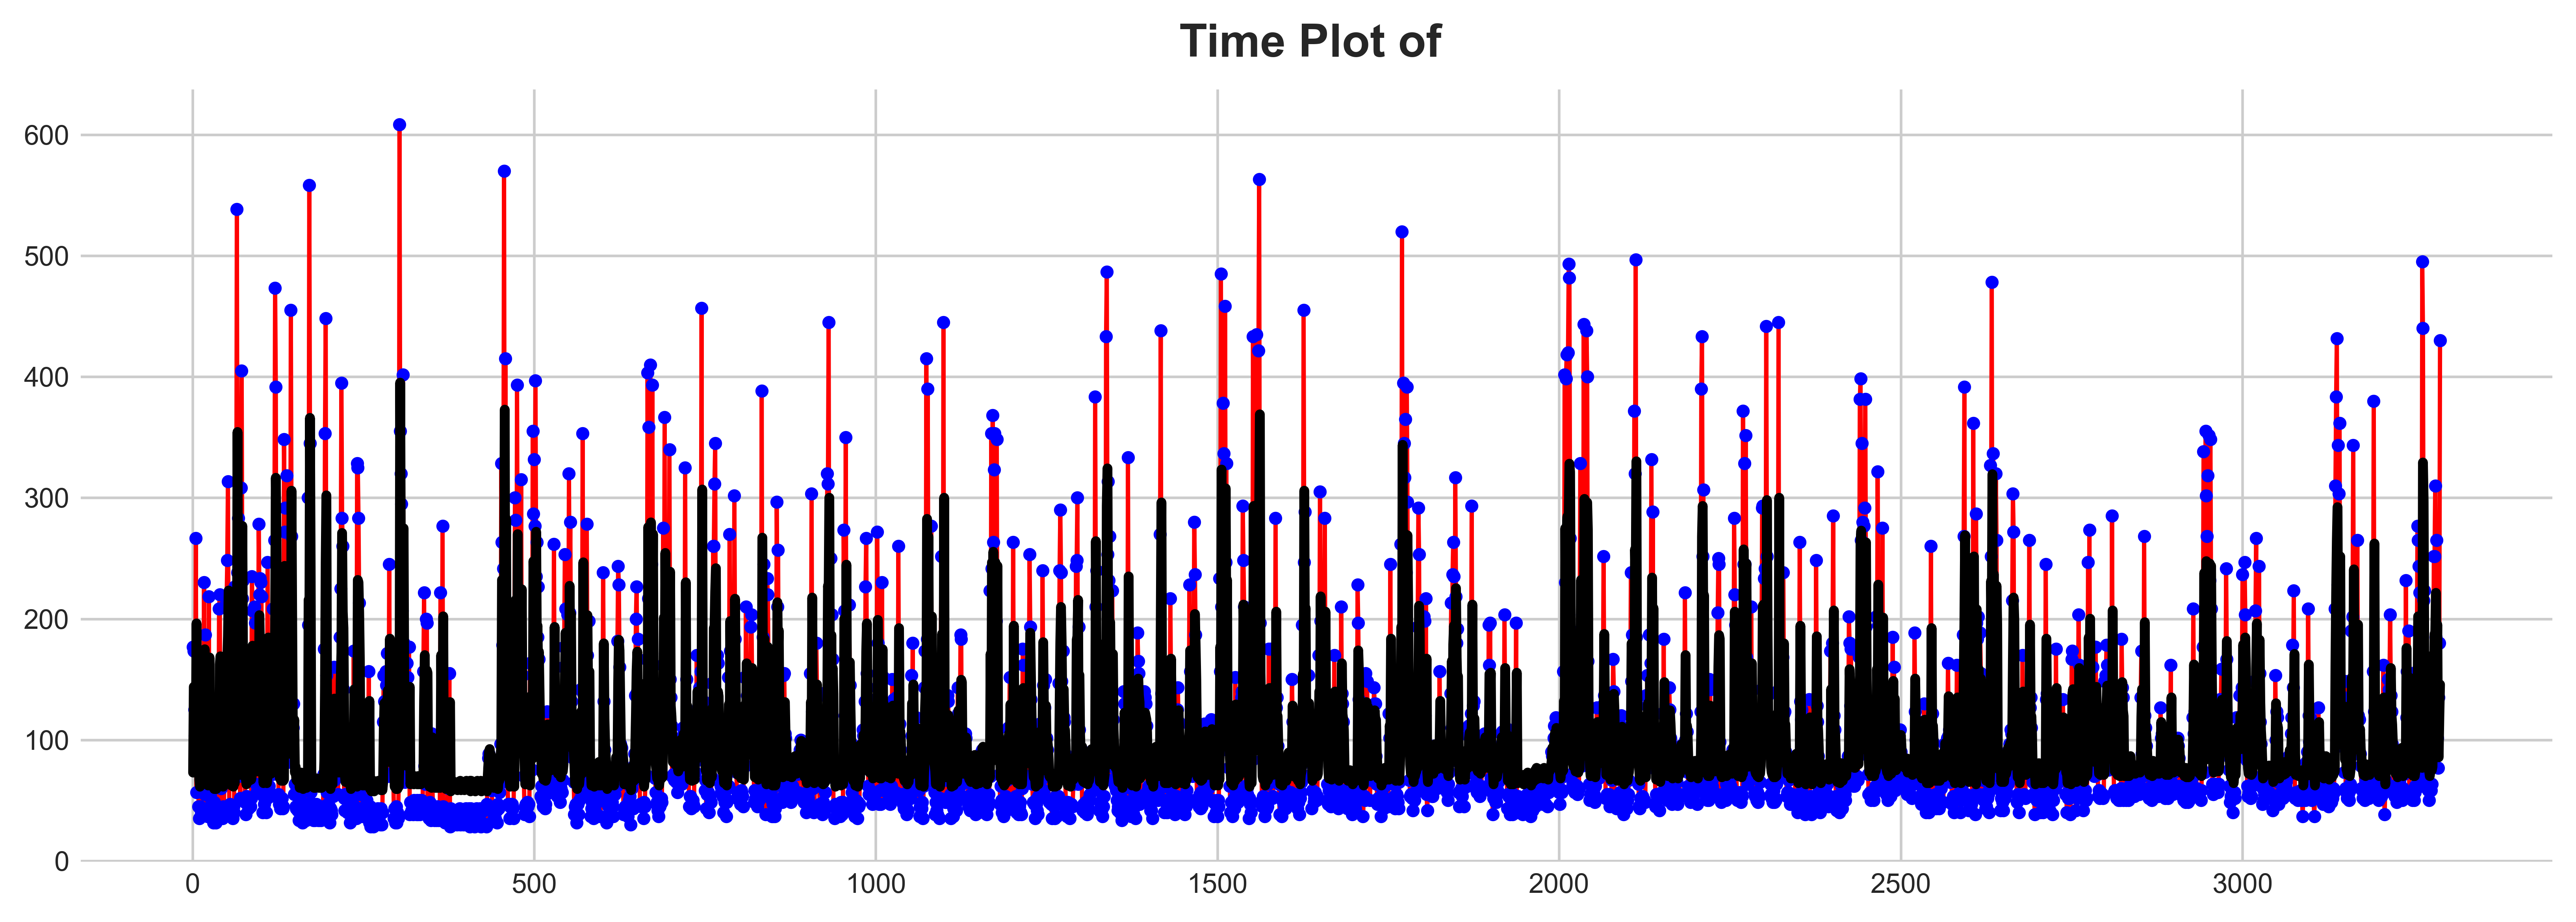

In [102]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of ');

In [93]:
ed_dt2['Lag_1'] = ed_dt2['appl'].shift(1)
ed_dt2.head()

date        appl  Time       Lag_1
0 2016-01-11 17:00:00   55.000000     0         NaN
1 2016-01-11 18:00:00  176.666667     1   55.000000
2 2016-01-11 19:00:00  173.333333     2  176.666667
3 2016-01-11 20:00:00  125.000000     3  173.333333
4 2016-01-11 21:00:00  103.333333     4  125.000000

In [94]:
from sklearn.linear_model import LinearRegression

X = ed_dt2.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = ed_dt2.loc[:, 'appl']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

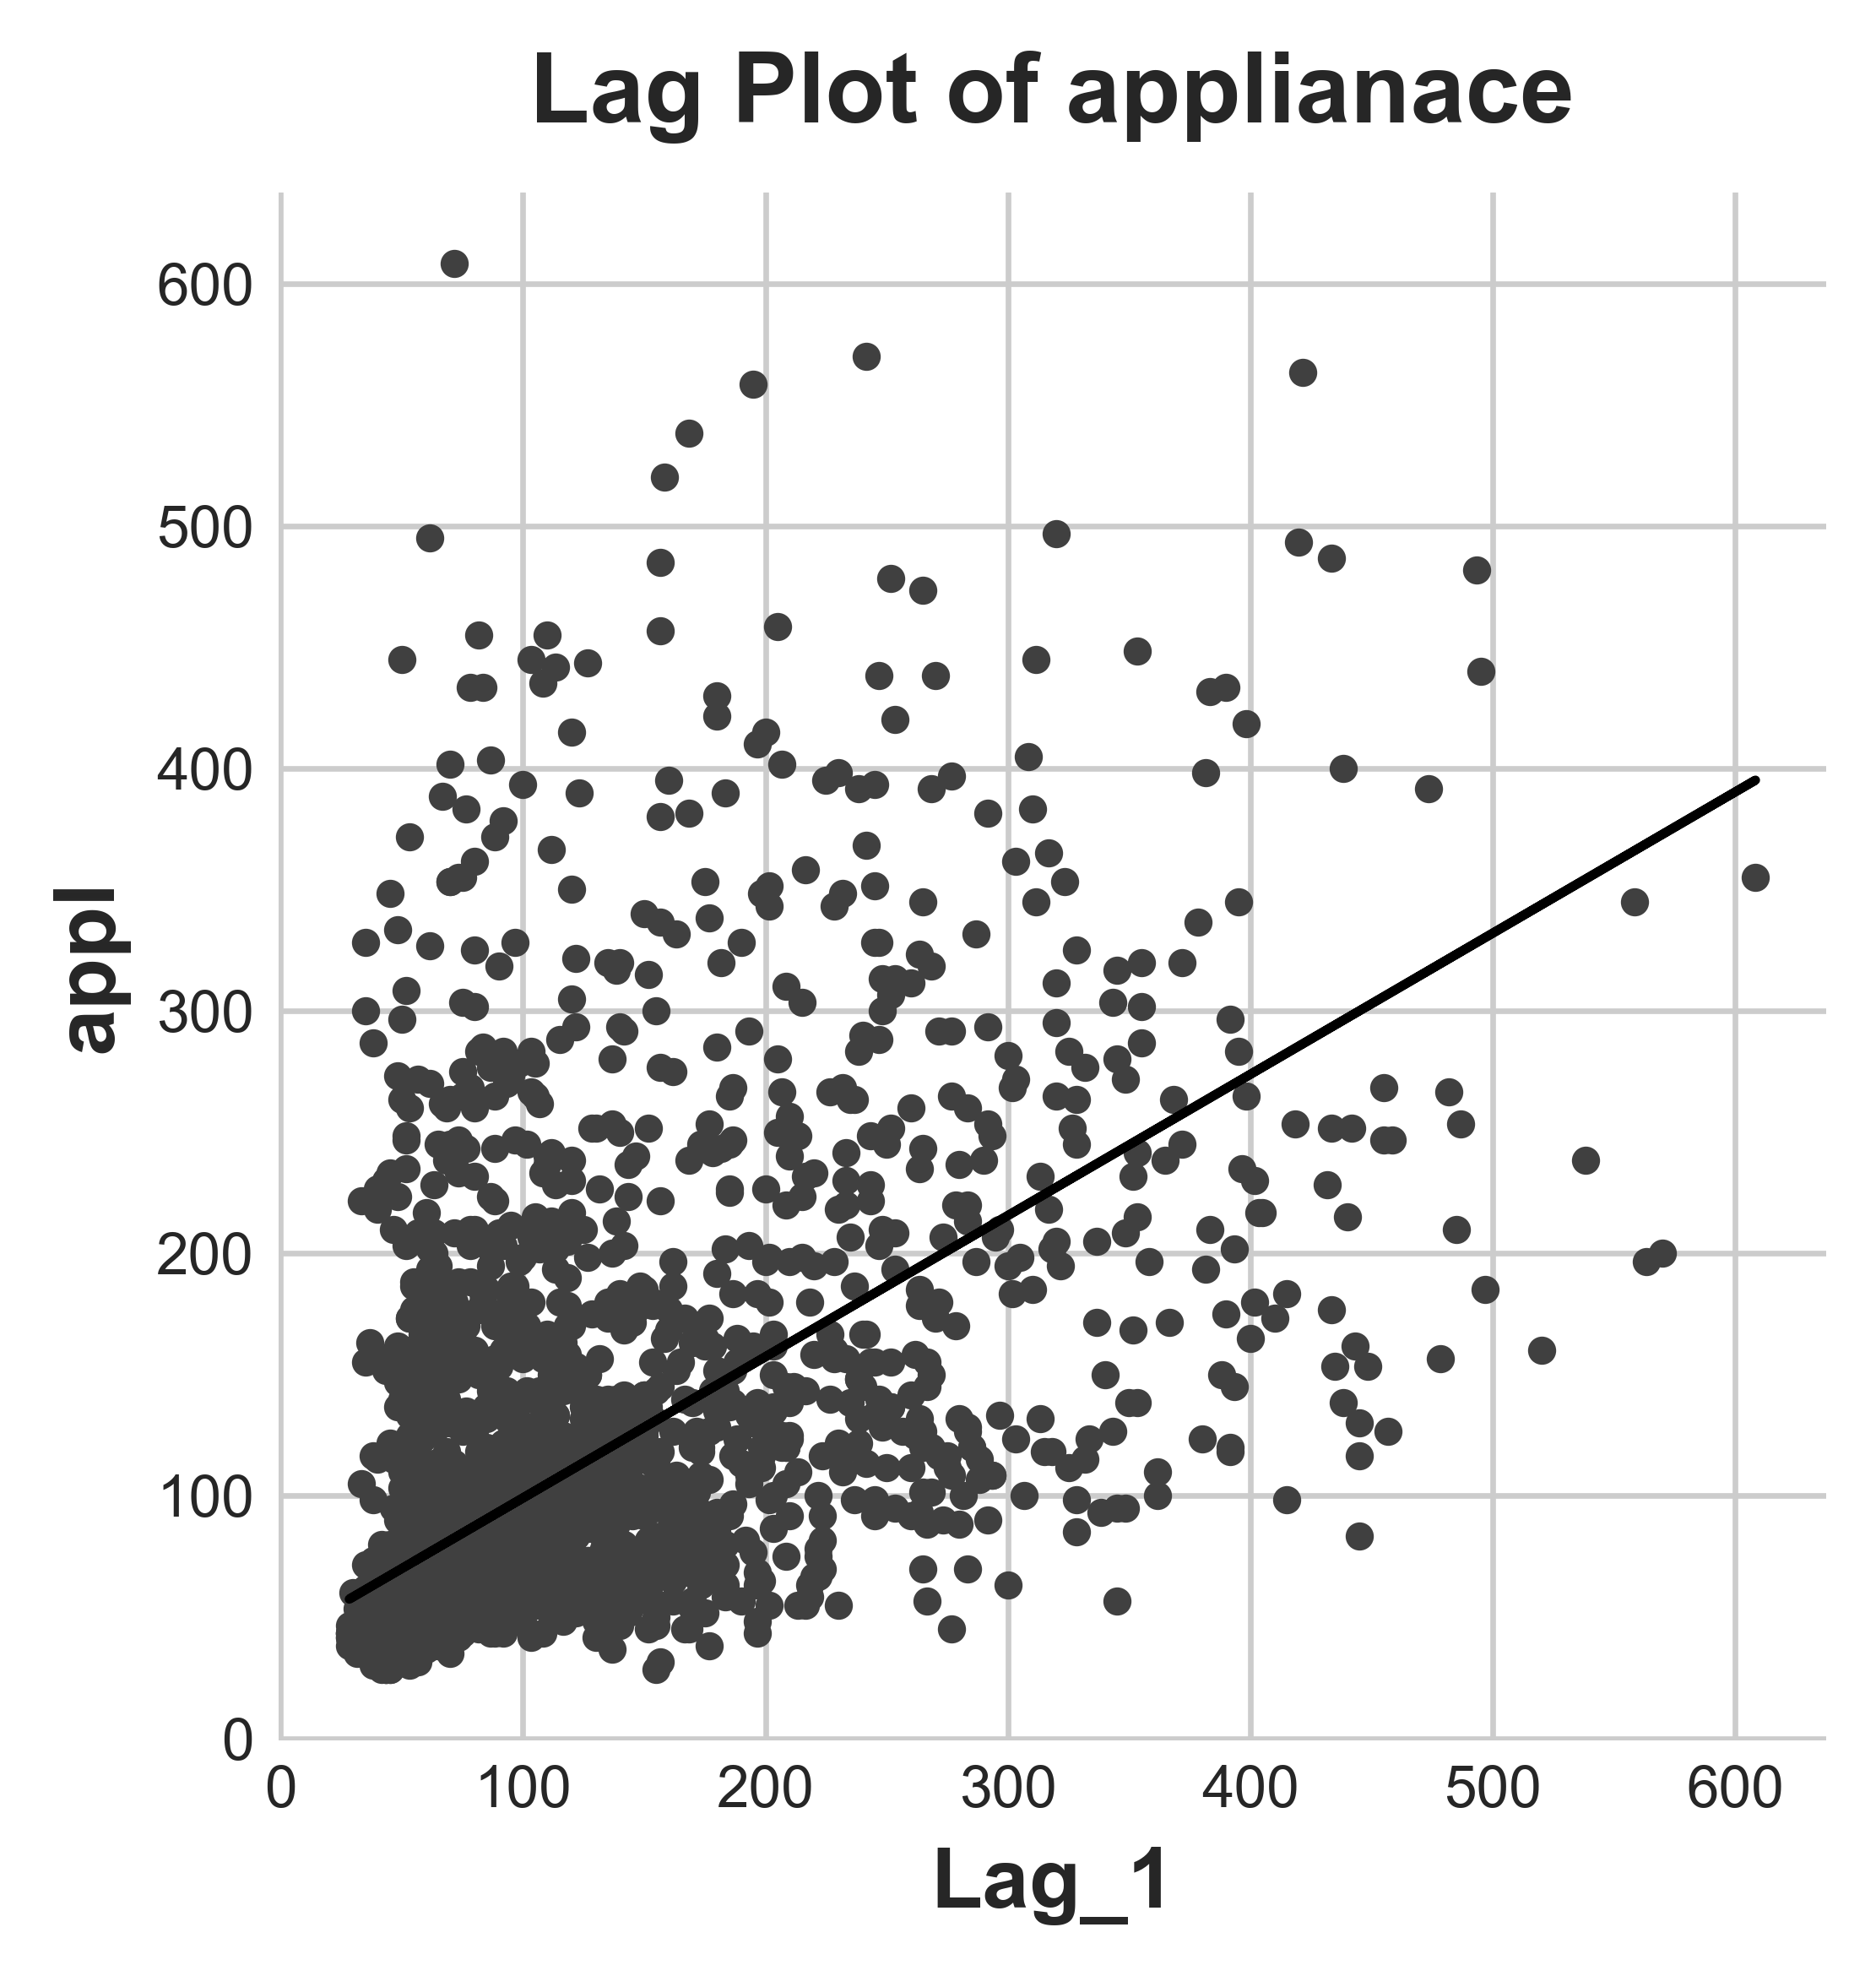

In [99]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('appl')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of applianace');

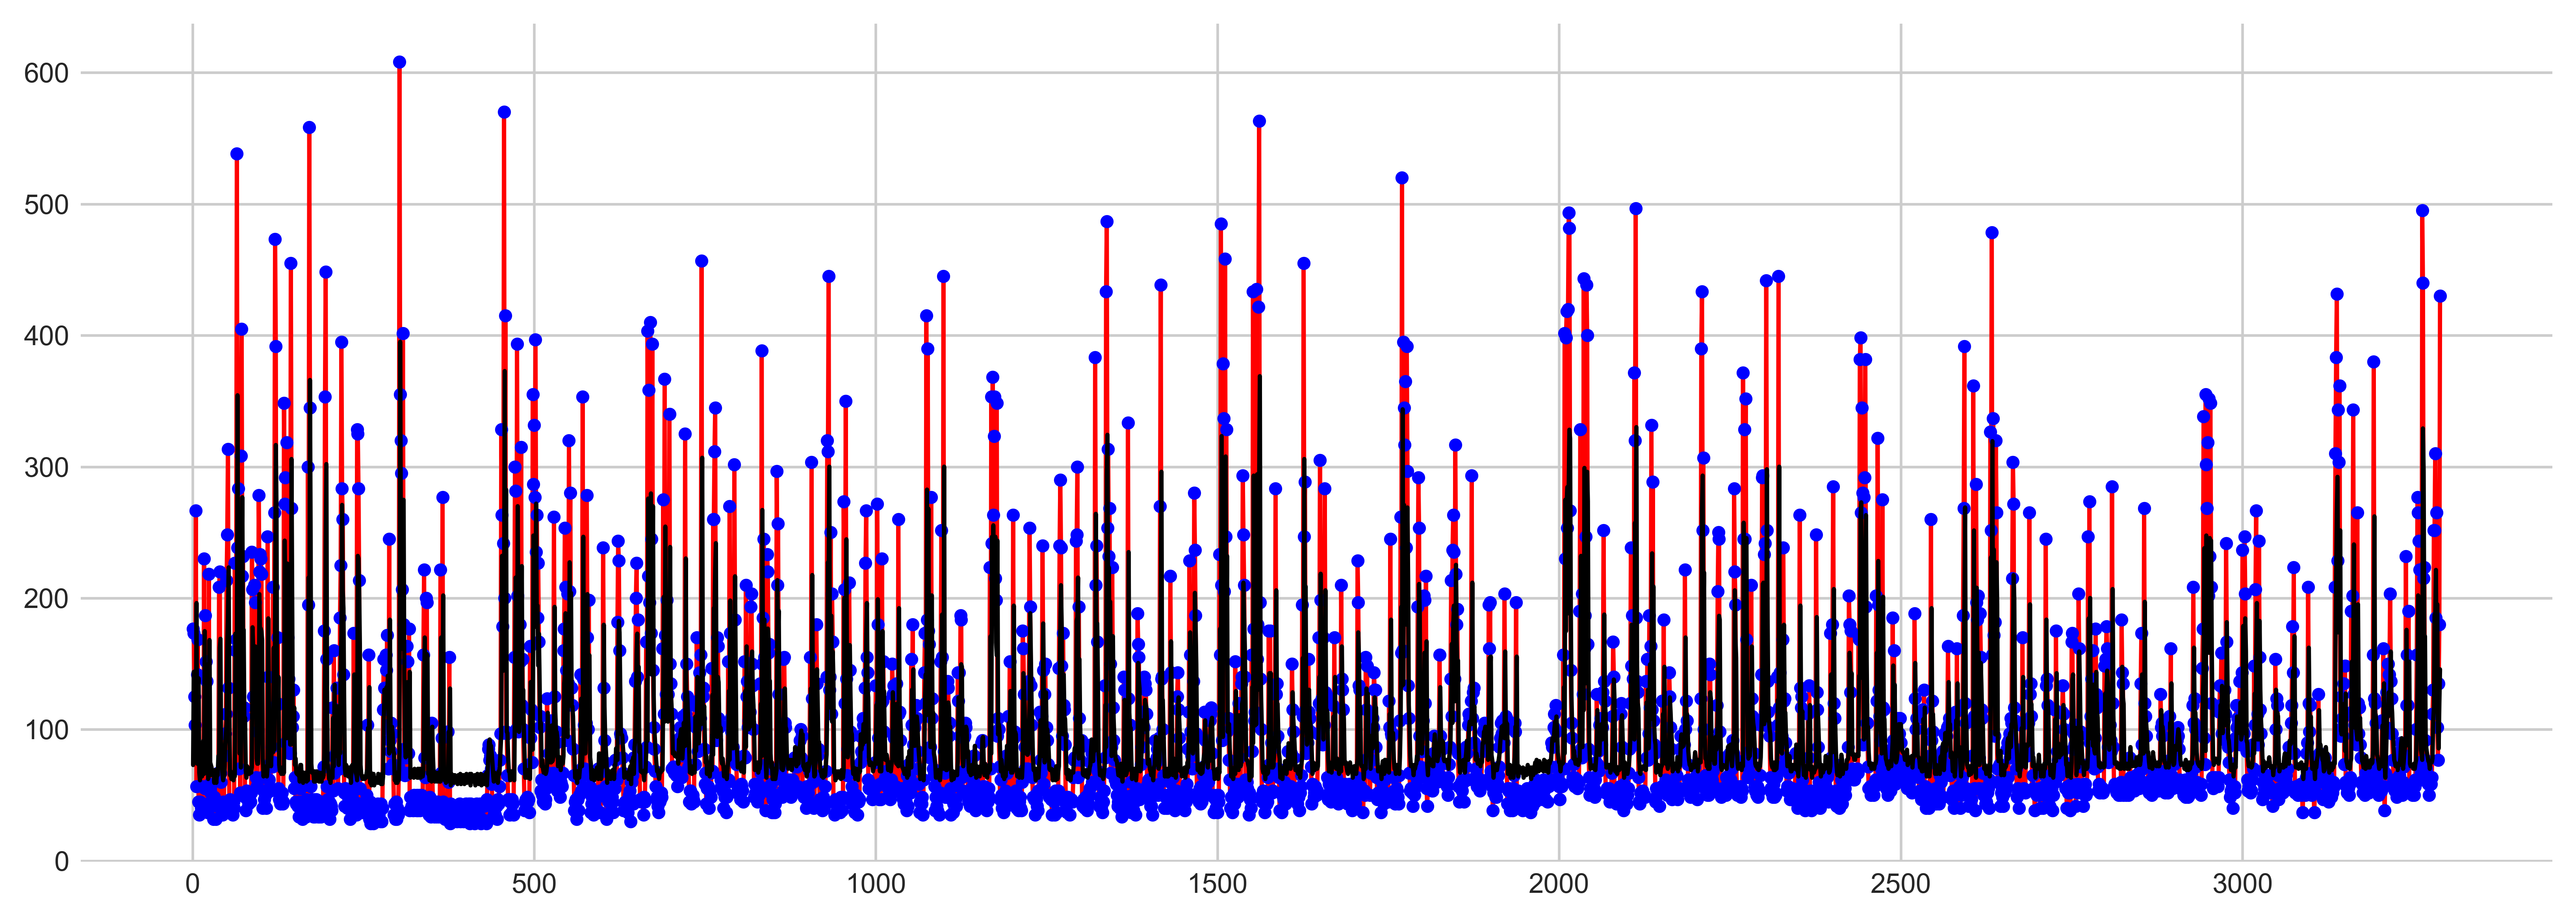

In [103]:
ax = y.plot(**plot_params)
ax = y_pred.plot()